In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My Drive/NoteBooks/Unet-Dr_Rahman

/content/drive/My Drive/NoteBooks/Unet-Dr_Rahman


In [10]:
#import all the libraries
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import os
import cv2
import glob
import skimage.io as io
from PIL import Image
from skimage.viewer import ImageViewer
import matplotlib.pyplot as plt
from model import *

In [ ]:
def trainGenerator(image_path,mask_path,flag_multi_class = False,num_class = 2,image_prefix = "image",mask_prefix = "mask",image_as_gray = True,mask_as_gray = True):
    image_name_arr = glob.glob(os.path.join(image_path,"*.png"))
    mask_name_arr = glob.glob(os.path.join(mask_path, "*.png"))
    image_arr = []
    mask_arr = []
    for index,item in enumerate(image_name_arr):
        img = io.imread(item,as_gray = image_as_gray)
        img = np.reshape(img,img.shape + (1,)) if image_as_gray else img
        img = img / 255
        image_arr.append(img)

    for index, item in enumerate(mask_name_arr):
        mask = io.imread(item, as_gray = image_as_gray)
        mask = np.reshape(mask,mask.shape + (1,)) if mask_as_gray else mask
        mask = mask/255
        mask[mask>0.5] = 1
        mask[mask<=0.5] = 0
        mask_arr.append(mask)

    image_arr = np.array(image_arr)
    mask_arr = np.array(mask_arr)
    return image_arr,mask_arr

In [25]:
def testGenerator(test_path, image_num):
    for i in range(image_num):
        x = 70+i
        #idx = str(i+1).zfill(5) + ".png"
        idx = 'rgb_' +str(x)+".png"
        print(idx)
        img = io.imread(os.path.join(test_path, idx), as_gray=True)
        img = img / 255
        img = np.reshape(img, img.shape + (1,))
        img = np.reshape(img,(1,)+img.shape)
        yield img

In [29]:
def getItem(img_path, item):
    idx = str(item+1).zfill(5) + ".png"
    img = io.imread(os.path.join(img_path, idx), as_gray=True)
    img = img/255.0
    img = np.reshape(img, img.shape + (1,))
    img = np.reshape(img,(1,)+img.shape)
    return img

In [11]:
def saveResult(save_path, files):
    for i, item in enumerate(files):
        img = item[:,:,0]
        idx = str(i+1).zfill(5) + ".png"
        #io.imsave(os.path.join(save_path, idx), img)
        cv2.imwrite(os.path.join(save_path, idx), img)

In [ ]:
def viewImage(array1, array2, i):
    img = np.reshape(array1[i], (512, 512))
    mask = np.reshape(array2[i], (512, 512))
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(img, cmap=plt.cm.gray)
    axarr[1].imshow(mask, cmap=plt.cm.gray)
    plt.show()

(69, 512, 512, 1)
(69, 512, 512, 1)


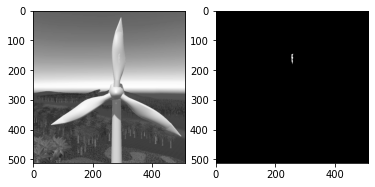

In [ ]:
# Load the train data and their corresponding labels
# Visualize a sample image
imgs_train,imgs_mask_train= trainGenerator("train/images/","train/masks/")
print(imgs_train.shape)   
print(imgs_mask_train.shape)
index = np.random.randint(1, 81)
viewImage(imgs_train, imgs_mask_train, index)

In [6]:
# laod model and show the model summary
model = unet()
model_checkpoint = ModelCheckpoint('windTurbine_segmentation.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Total params: 31,031,685
Trainable params: 31,031,685
Non-trainable params: 0
__________________________________________________________________________________________________


In [ ]:
# train the model
hm_epochs = 50
batch_size = 5
model.fit(imgs_train, imgs_mask_train, batch_size=batch_size, epochs=hm_epochs, verbose=1,
          validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])

Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.4040 - accuracy: 0.9094
Epoch 1: loss improved from inf to 0.40401, saving model to windTurbine_segmentation.hdf5
11/11 [==============================] - 54s 2s/step - loss: 0.4040 - accuracy: 0.9094 - val_loss: 0.0292 - val_accuracy: 0.9995
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.0649 - accuracy: 0.9995
Epoch 2: loss improved from 0.40401 to 0.06487, saving model to windTurbine_segmentation.hdf5
11/11 [==============================] - 18s 2s/step - loss: 0.0649 - accuracy: 0.9995 - val_loss: 0.0125 - val_accuracy: 0.9995
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.0137 - accuracy: 0.9995
Epoch 3: loss improved from 0.06487 to 0.01367, saving model to windTurbine_segmentation.hdf5
11/11 [==============================] - 19s 2s/step - loss: 0.0137 - accuracy: 0.9995 - val_loss: 0.0127 - val_accuracy: 0.9995
Epoch 4/50
11/11 [==============================] - E

In [26]:
# testing with new images
# the test image folder contains 30 images
test_path = 'test/images/'
test_image_arr = glob.glob(os.path.join(test_path, "*.png"))
num_of_test_images = len(test_image_arr)
print(num_of_test_images)

testGene = testGenerator(test_path, num_of_test_images)

results = model.predict(testGene, num_of_test_images, verbose=1)

# save the segmentation result in the "outputs" folder
saveResult("outputs/", results)

12
rgb_70.png
rgb_71.png
      1/Unknown - 8s 8s/steprgb_72.png
      2/Unknown - 15s 8s/steprgb_73.png
      3/Unknown - 23s 8s/steprgb_74.png
      4/Unknown - 30s 8s/steprgb_75.png
      5/Unknown - 40s 8s/steprgb_76.png
      6/Unknown - 48s 8s/steprgb_77.png
      7/Unknown - 55s 8s/steprgb_78.png
      8/Unknown - 63s 8s/steprgb_79.png
      9/Unknown - 70s 8s/steprgb_80.png
     10/Unknown - 78s 8s/steprgb_81.png
12/12 [==============================] - 93s 8s/step


In [27]:
# load the trained model
print("model loading...")
trained_model = load_model('windTurbine_segmentation.hdf5')
print("model loaded succesfully!!!")

model loading...
model loaded succesfully!!!


In [31]:
# showing the demo with any random number of images from the test folder
hm_demo = 5
idxs = np.random.randint(1, 10, hm_demo)
for item in idxs:
    testimg = getItem(test_path, item)
    result = trained_model.predict(testimg)
    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(np.reshape(testimg, (256, 256)), cmap='gray')
    axarr[1].imshow(np.reshape(result, (256,256)), cmap='gray')

FileNotFoundError: ignored